# Tests
The objective here is to summarize and summarize results from different response variables, initialization methods and different models using R2

In [151]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from collections import Counter

sns.set_theme(rc={'figure.figsize':(15,20)})
sns.set_style("whitegrid")
sns.set_palette("deep")
sns.set_context("paper")
sns.set_theme(palette="flare", style='whitegrid', context='paper')

CONSENSUS_TIME = 'consensus_time'
OPINION_CHANGE_FREQUENCY = 'opinion_change_frequency'

FEATURES = [
    'clustering', 'closeness', 'betweenness',
    'average_shortest_path_lenght', 'eigenvector', 'assortativity',
    'information_centrality',
    'approximate_current_flow_betweenness_centrality', 'shannon_entropy',
    'degree_variance'
]

TITLE_FEATURES = [
    'Clustering', 'Closeness', 'Betweenness',
    'Avg. Shortest Path', 'Eigenvector', 'Assortativity',
    'Information',
    'Appr. Current Flow', 'Entropy',
    'Degree Variance'
]

In [19]:
dataset = pd.read_csv('../data/dataset.csv')

In [177]:
def plot_importance(feature_importance: dict):
    df = pd.DataFrame(feature_importance).T
    df.columns = TITLE_FEATURES
    df = df.T.sort_values(by=['random', 'direct', 'inverse'], ascending=False).T
    melt_df = pd.melt(df, var_name='metric', ignore_index=False)
    melt_df.index.name = 'Inicialização'
    melt_df = melt_df.reset_index()
    g = sns.catplot(data=melt_df, kind='bar', x='metric', hue='Inicialização', y='value', aspect=3, height=6)
    g.set_axis_labels("", "Feature")
    g.set_xticklabels(rotation=30)

## Imports

In [20]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, GroupKFold, StratifiedGroupKFold, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PoissonRegressor, TweedieRegressor, LinearRegression
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
import optuna

## Metrics

In [21]:
p = 1
from sklearn.metrics import r2_score

def adjusted_r2_score(y: np.array, y_hat: np.array):
    """
    Computes R² score. It decreases if many variables are introduced.
    n: number of observations in sample 
    p: number of independent variables
    """
    n = len(y_hat)
    return 1 - ((1 - r2_score(y, y_hat)) * ((n - 1)/(n - p - 1)))

## Linear Regression CV

In [22]:
def LinearRegressionCV(X, y):
    cross_validation = KFold(n_splits=10)

    splits = cross_validation.split(
        X,
        y=y
    )

    score_list = []
    feature_list = []
    
    regressor = LinearRegression()
    feature_selector = SequentialFeatureSelector(
        regressor,
        # tol=0.01,
        n_features_to_select=2,
        direction='forward'
    )
    
    for train_index, val_index in splits:
        _X_train, _X_val = X.iloc[train_index], X.iloc[val_index]
        _y_train, _y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Feature selection
        sfs = clone(feature_selector) 
        sfs.fit(_X_train, _y_train)
        selected_subset = np.array(FEATURES)[sfs.get_support()]
        p = len(selected_subset)

        # Evaluation
        model = clone(regressor)
        model.fit(_X_train[selected_subset], _y_train)
        y_val_pred = model.predict(_X_val[selected_subset])
        
        score = adjusted_r2_score(np.exp(_y_val), np.exp(y_val_pred))
        score_list.append(score)

        for selected_feature in selected_subset:
            feature_list.append(str(selected_feature))

    cv_subset = []
    for feature, _ in Counter(feature_list).most_common():
        cv_subset.append(feature)

    print(f'Mean Score: {np.mean(score_list):.3f}')

    if np.mean(score_list) < 0.9:
        print(score_list)
    
    return cv_subset[:2]

In [23]:
feature_scaler = StandardScaler()

## Linear Regression Tests

In [24]:
results_dict = {
    OPINION_CHANGE_FREQUENCY: {},
    CONSENSUS_TIME: {}
}

for response_variable in [OPINION_CHANGE_FREQUENCY, CONSENSUS_TIME]:
    for initialization in ['random', 'direct', 'inverse']:
        # Prepare dataset
        filtered_dataset = dataset[dataset['initialization'] == initialization]
        X = filtered_dataset[FEATURES]
        y = np.log(filtered_dataset[response_variable])
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=0
        )

        # Scale and standardize
        feature_scaler.fit(X_train[FEATURES])
        X_train[FEATURES] = feature_scaler.transform(X_train[FEATURES])
        X_test[FEATURES] = feature_scaler.transform(X_test[FEATURES])
        
        # Select variables using Forward Selection
        selected_subset = LinearRegressionCV(X_train, y_train)

        # Train and predict
        model = LinearRegression()
        model.fit(X_train[selected_subset], y_train)
        y_train_pred = model.predict(X_train[selected_subset])
        train_score = adjusted_r2_score(y_train_pred, y_train)
        y_test_pred = model.predict(X_test[selected_subset])
        test_score = adjusted_r2_score(y_test_pred, y_test)

        # Save
        instance_dict = {
            'r2_train': train_score,
            'r2_test': test_score,
            'selected_features': selected_subset 
        }
        results_dict[response_variable][initialization] = instance_dict


Mean Score: 0.955
Mean Score: 0.967
Mean Score: 0.974
Mean Score: 0.974
Mean Score: 0.984
Mean Score: 0.746
[0.9299995563058387, 0.21180410323479226, 0.8600378555920577, 0.8841594472540377, 0.7927217012196519, 0.8755086476975742, 0.9542914342266154, 0.4593271759947726, 0.7101048803048069, 0.7834558479417517]


In [26]:
print(pd.DataFrame(results_dict['opinion_change_frequency']).T.to_markdown())

|         |   r2_train |   r2_test | selected_features                                                 |
|:--------|-----------:|----------:|:------------------------------------------------------------------|
| random  |   0.990079 |  0.991429 | ['clustering', 'approximate_current_flow_betweenness_centrality'] |
| direct  |   0.996712 |  0.997618 | ['clustering', 'eigenvector']                                     |
| inverse |   0.994699 |  0.994797 | ['clustering', 'information_centrality']                          |


In [27]:
print(pd.DataFrame(results_dict['consensus_time']).T.to_markdown())

|         |   r2_train |   r2_test | selected_features                |
|:--------|-----------:|----------:|:---------------------------------|
| random  |   0.99348  |  0.993645 | ['closeness', 'degree_variance'] |
| direct  |   0.990872 |  0.98803  | ['closeness', 'shannon_entropy'] |
| inverse |   0.991937 |  0.993568 | ['closeness', 'betweenness']     |


## Random Forests Tests

In [54]:
results_dict = {
    OPINION_CHANGE_FREQUENCY: {},
    CONSENSUS_TIME: {}
}

feature_importance = {
    OPINION_CHANGE_FREQUENCY: {},
    CONSENSUS_TIME: {}
}

for response_variable in [OPINION_CHANGE_FREQUENCY, CONSENSUS_TIME]:
    for initialization in ['random', 'direct', 'inverse']:
        # Prepare dataset
        filtered_dataset = dataset[dataset['initialization'] == initialization]
        X = filtered_dataset[FEATURES]
        y = filtered_dataset[response_variable]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=0
        )

        # Train and predict
        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        train_score = adjusted_r2_score(y_train_pred, y_train)
        y_test_pred = model.predict(X_test)
        test_score = adjusted_r2_score(y_test_pred, y_test)

        # Save
        instance_dict = {
            'r2_train': train_score,
            'r2_test': test_score,
        }
        results_dict[response_variable][initialization] = instance_dict
        feature_importance[response_variable][initialization] = model.feature_importances_


### Frequência de Troca de Opinião

In [184]:
print(pd.DataFrame(results_dict[OPINION_CHANGE_FREQUENCY]).T.to_markdown())

|         |   r2_train |   r2_test |
|:--------|-----------:|----------:|
| random  |   0.992962 |  0.972243 |
| direct  |   0.998287 |  0.97834  |
| inverse |   0.997661 |  0.98734  |


Text(0.5, 1.0, 'Importância das Features na Frequência de Troca de Opinião')

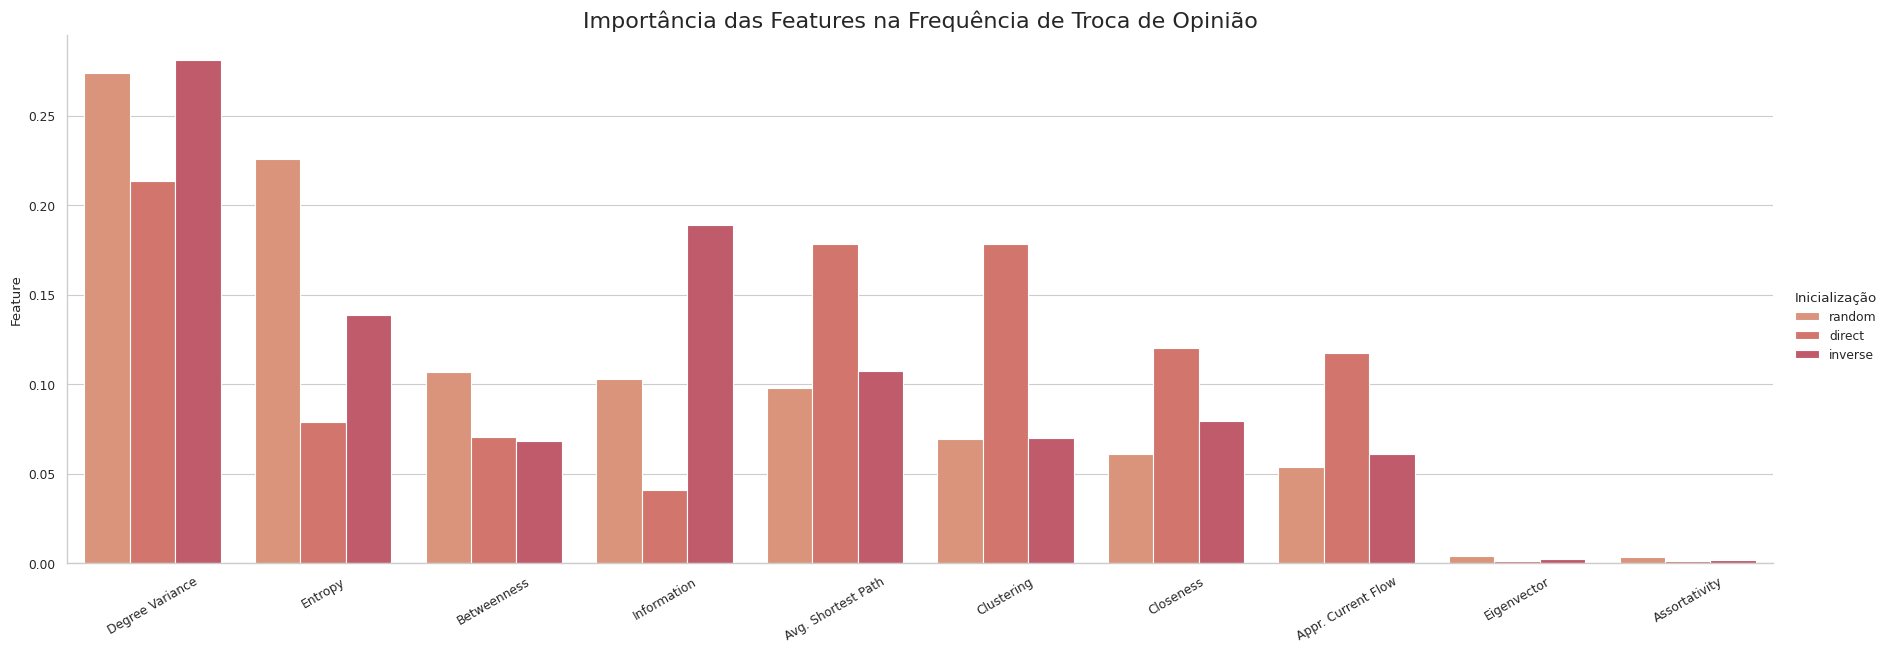

In [183]:
plot_importance(feature_importance[OPINION_CHANGE_FREQUENCY])
plt.title('Importância das Features na Frequência de Troca de Opinião',fontsize=16)

### Tempo de Consenso

In [185]:
print(pd.DataFrame(results_dict[CONSENSUS_TIME]).T.to_markdown())

|         |   r2_train |   r2_test |
|:--------|-----------:|----------:|
| random  |   0.996251 |  0.984159 |
| direct  |   0.997946 |  0.965798 |
| inverse |   0.997352 |  0.984966 |


Text(0.5, 1.0, 'Importância das Features no Tempo de Consenso')

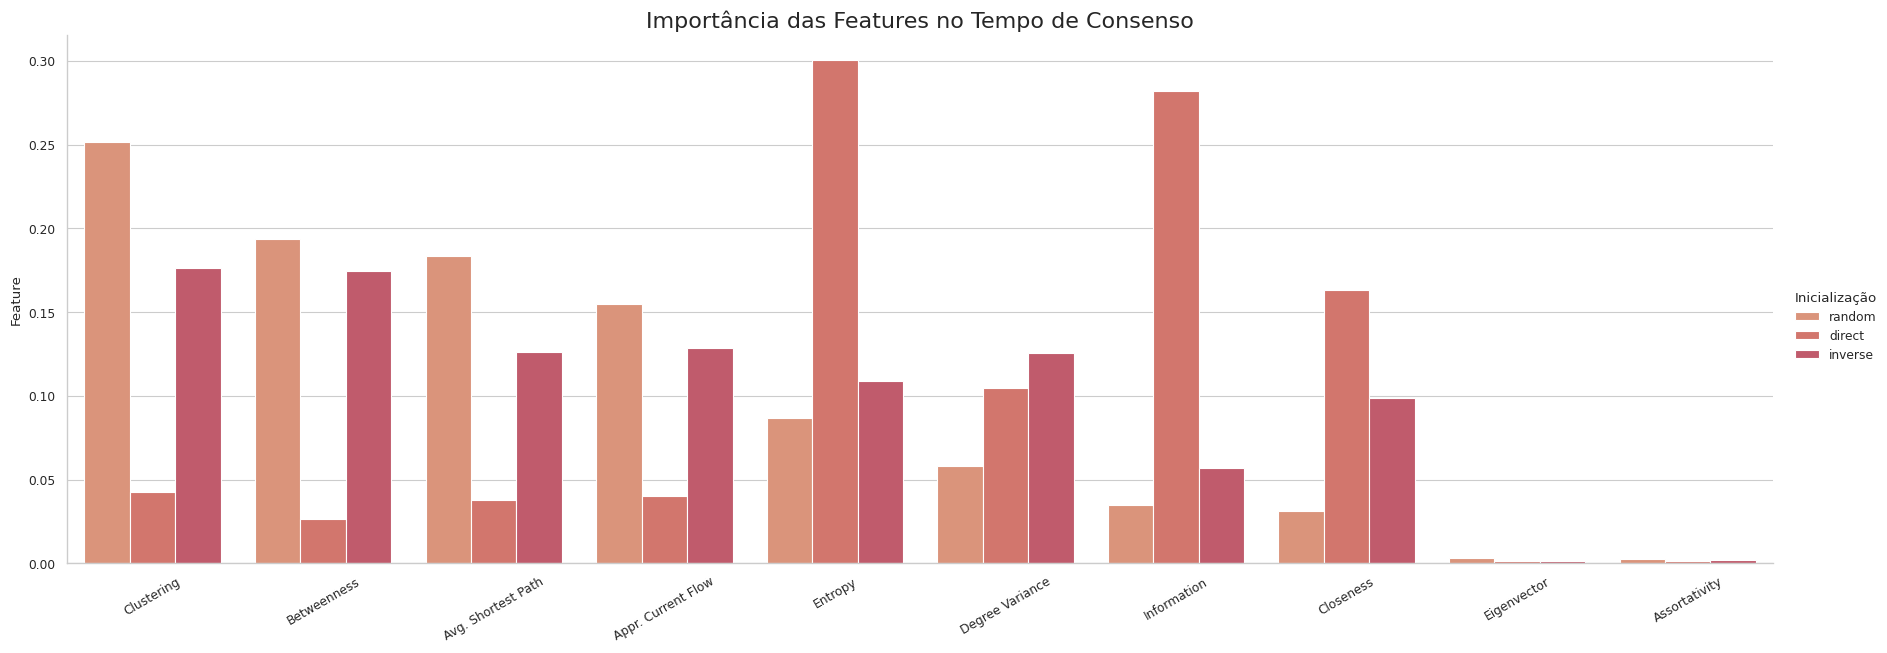

In [186]:
plot_importance(feature_importance[CONSENSUS_TIME])
plt.title('Importância das Features no Tempo de Consenso',fontsize=16)